# Word2Vec (Word Embedding)

Implement Word2Vec algorithm to compute vector representations of words, with TensorFlow 2.0. This example is using a small chunk of Wikipedia articles to train from.

More info: [Mikolov, Tomas et al. "Efficient Estimation of Word Representations in Vector Space.", 2013](https://arxiv.org/pdf/1301.3781.pdf)

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from __future__ import division, print_function, absolute_import

import collections
import os
import sys
import random
import urllib
import zipfile
import tqdm

import numpy as np
import tensorflow as tf

In [3]:
print(sys.version, '\n', tf.__version__)
tf.debugging.set_log_device_placement(True)

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0] 
 2.1.0


In [0]:
# Training Parameters.
learning_rate = 0.1
batch_size = 128
num_steps = 300000#1000#3000000
display_step = 1000#100 #10000
eval_step = 20000#100 #200000

# Evaluation Parameters.
eval_words = [b'five', b'of', b'going', b'hardware', b'american', b'britain']

# Word2Vec Parameters.
embedding_size = 200 # Dimension of the embedding vector.
max_vocabulary_size = 50000 # Total number of different words in the vocabulary.
min_occurrence = 10 # Remove all words that does not appears at least n times.
skip_window = 3 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
num_sampled = 64 # Number of negative examples to sample.

In [0]:
############################################################
## code below shows how to get/upload files from/to Drive ## 
############################################################

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [9]:
# to search for file or folder id string
# navigate to file or folder in authentified Google Drive
# right-click on file or folder icon and select "Get shareable link"
# the string contains required string

required_file = 'text8.zip'# a small chunk of Wikipedia articles collection

file_list = drive.ListFile({'q': "'1yptTxtGdJN_Dleg4Uhvc0_3Ac6OKfKOa' in parents"}).GetList()
file_index = [i for i, file in enumerate(file_list) if file['title'] == required_file]

if os.path.exists(required_file):
  print("File already exists in {}".format(os.getcwd()))
elif file_index:
  print("Getting the file from authentified Google Drive...")
  f = file_list[file_index[0]]
  f_name = f['title']
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(f_name)
else:
  # get file from the web
  url = 'http://mattmahoney.net/dc/text8.zip'
  print("Downloading the dataset... (It may take some time)")
  filename, _ = urllib.request.urlretrieve(url, required_file)
  print("Done!")

# this would upload files to the Google Drive
if not file_list:
  print("File is not in Google Drive folder. Uploading...")
  file = drive.CreateFile()
  file.SetContentFile(required_file)
  file.Upload()

# Unzip the dataset file. Text has already been processed
with zipfile.ZipFile(required_file) as f:
    text_words = f.read(f.namelist()[0]).lower().split()

Getting the file from authentified Google Drive...


In [10]:
# Build the dictionary and replace rare words with UNK token.
count = [('UNK', -1)]
# Retrieve the most common words.
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences.
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached.
        break
# Compute the vocabulary size.
vocabulary_size = len(count)
# Assign an id to each word.
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i

data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary.
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)
id2word = dict(zip(word2id.values(), word2id.keys()))

print("Words count:", len(text_words))
print("Unique words:", len(set(text_words)))
print("Vocabulary size:", vocabulary_size)
print("Most common words:", count[:10])

Words count: 17005207
Unique words: 253854
Vocabulary size: 47135
Most common words: [('UNK', 444176), (b'the', 1061396), (b'of', 593677), (b'and', 416629), (b'one', 411764), (b'in', 372201), (b'a', 325873), (b'to', 316376), (b'zero', 264975), (b'nine', 250430)]


In [0]:
data_index = 0
# Generate training batch for the skip-gram model.
def next_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # get window size (words left and right + current one).
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch.
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [12]:
# GPU try
# device_spec = tf.DeviceSpec()
device_spec = tf.DeviceSpec(device_type="GPU") # combining these
device_spec2 = tf.DeviceSpec(device_type="CPU")

with tf.device(device_spec):
  embedding = tf.Variable(tf.random.normal([vocabulary_size, embedding_size]))
  # Construct the variables for the NCE loss.
  nce_weights = tf.Variable(tf.random.normal([vocabulary_size, embedding_size]))
  nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

def get_embedding(x):
# with tf.device('/cpu:0'):
  with tf.device(device_spec):
    # Lookup the corresponding embedding vectors for each sample in X.
    x_embed = tf.nn.embedding_lookup(embedding, x)
    return x_embed

def nce_loss(x_embed, y):
# with tf.device('/cpu:0'):
  with tf.device(device_spec):
    # Compute the average NCE loss for the batch.
    y = tf.cast(y, tf.int64)
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                        biases=nce_biases,
                        labels=y,
                        inputs=x_embed,
                        num_sampled=num_sampled,
                        num_classes=vocabulary_size))
    return loss

# Evaluation.
def evaluate(x_embed):
  with tf.device(device_spec):
    # with tf.device('/cpu:0'):
    # Compute the cosine similarity between input data embedding and every embedding vectors
    x_embed = tf.cast(x_embed, tf.float32)
    x_embed_norm = x_embed / tf.sqrt(tf.reduce_sum(tf.square(x_embed)))
    embedding_norm = embedding / tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True), tf.float32)
    cosine_sim_op = tf.matmul(x_embed_norm, embedding_norm, transpose_b=True)
    return cosine_sim_op



# Optimization process. 
def run_optimization(x, y):
  # with tf.device('/cpu:0'):
  with tf.device(device_spec):
  # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        emb = get_embedding(x)
        loss = nce_loss(emb, y)

    # Compute gradients.
    gradients = g.gradient(loss, [embedding, nce_weights, nce_biases])

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, [embedding, nce_weights, nce_biases]))

# Define the optimizer.
with tf.device(device_spec):
  optimizer = tf.optimizers.SGD(learning_rate)

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [14]:
# Words for testing.
x_test = np.array([word2id[w] for w in eval_words])

# Run training for the given number of steps.
for step in tqdm.tqdm(range(1, num_steps + 1)):
    batch_x, batch_y = next_batch(batch_size, num_skips, skip_window)
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0 or step == 1:
        loss = nce_loss(get_embedding(batch_x), batch_y)
        print("step: %i, loss: %f" % (step, loss))
        
    # Evaluation.
    if step % eval_step == 0 or step == 1:
        print("Evaluation...")
        sim = evaluate(get_embedding(x_test)).numpy()
        for i in range(len(eval_words)):
            top_k = 8  # number of nearest neighbors.
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]
            log_str = '"%s" nearest neighbors:' % eval_words[i]
            for k in range(top_k):
                log_str = '%s %s,' % (log_str, id2word[nearest[k]])
            print(log_str)

  0%|          | 0/300000 [00:00<?, ?it/s]

Executing op ResourceGather in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogUniformCandidateSampler in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StopGradient in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StopGradient in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ResourceGather in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Slice in device /job:localhost/re

  0%|          | 1/300000 [00:01<153:19:42,  1.84s/it]

"b'american'" nearest neighbors: b'housemates', b'subsonic', b'seminal', b'slowing', b'iaea', b'wove', b'grammar', b'benoit',
"b'britain'" nearest neighbors: b'canard', b'leeuwenhoek', b'sanhedrin', b'negatively', b'faculty', b'unthinkable', b'proliferated', b'oromo',


  0%|          | 1018/300000 [00:12<49:28, 100.70it/s]

step: 1000, loss: 289.165924


  1%|          | 2012/300000 [00:22<54:03, 91.87it/s]

step: 2000, loss: 274.714661


  1%|          | 3014/300000 [00:32<49:12, 100.58it/s]

step: 3000, loss: 212.459198


  1%|▏         | 4010/300000 [00:42<52:38, 93.70it/s]

step: 4000, loss: 161.105347


  2%|▏         | 5013/300000 [00:52<48:29, 101.39it/s]

step: 5000, loss: 179.547623


  2%|▏         | 6012/300000 [01:01<47:57, 102.17it/s]

step: 6000, loss: 180.453003


  2%|▏         | 7010/300000 [01:11<48:38, 100.39it/s]

step: 7000, loss: 109.501709


  3%|▎         | 8010/300000 [01:21<50:01, 97.27it/s]

step: 8000, loss: 192.695587


  3%|▎         | 9021/300000 [01:31<46:18, 104.71it/s]

step: 9000, loss: 157.008026


  3%|▎         | 10020/300000 [01:41<47:01, 102.79it/s]

step: 10000, loss: 116.417938


  4%|▎         | 11019/300000 [01:51<47:41, 101.00it/s]

step: 11000, loss: 125.885918


  4%|▍         | 12018/300000 [02:00<47:32, 100.97it/s]

step: 12000, loss: 93.796059


  4%|▍         | 13018/300000 [02:10<46:03, 103.86it/s]

step: 13000, loss: 144.058716


  5%|▍         | 14020/300000 [02:20<45:34, 104.60it/s]

step: 14000, loss: 105.154724


  5%|▌         | 15016/300000 [02:29<46:32, 102.05it/s]

step: 15000, loss: 131.403458


  5%|▌         | 16019/300000 [02:39<46:07, 102.63it/s]

step: 16000, loss: 80.874657


  6%|▌         | 17021/300000 [02:49<45:19, 104.06it/s]

step: 17000, loss: 76.644638


  6%|▌         | 18012/300000 [02:58<46:42, 100.64it/s]

step: 18000, loss: 146.481598


  6%|▋         | 19016/300000 [03:08<45:25, 103.11it/s]

step: 19000, loss: 98.124817


  7%|▋         | 20017/300000 [03:17<47:32, 98.17it/s]

step: 20000, loss: 84.741920
Evaluation...
"b'five'" nearest neighbors: b'two', b'six', b'three', b'four', b'eight', b'seven', b'one', b'on',
"b'of'" nearest neighbors: b'and', b'the', b'a', b'in', b'to', b's', b'was', b'by',
"b'going'" nearest neighbors: b'very', b'modern', b'john', b'emperor', b'now', b'those', b'year', b'general',
"b'hardware'" nearest neighbors: b'classify', b'latin', b'apparently', b'alright', b't', b'rewind', b'until', b'titled',
"b'american'" nearest neighbors: b'not', b'also', b'or', b'by', b'is', b'was', b'an', b'from',
"b'britain'" nearest neighbors: b'system', b'use', b'those', b'd', b'will', b'city', b'b', b'about',


  7%|▋         | 21015/300000 [03:27<44:10, 105.27it/s]

step: 21000, loss: 105.468826


  7%|▋         | 22013/300000 [03:36<44:53, 103.22it/s]

step: 22000, loss: 87.337822


  8%|▊         | 23015/300000 [03:46<46:35, 99.10it/s]

step: 23000, loss: 67.285271


  8%|▊         | 24016/300000 [03:56<44:45, 102.79it/s]

step: 24000, loss: 72.467209


  8%|▊         | 25015/300000 [04:05<42:59, 106.59it/s]

step: 25000, loss: 53.891785


  9%|▊         | 26013/300000 [04:15<42:39, 107.05it/s]

step: 26000, loss: 91.552643


  9%|▉         | 27015/300000 [04:24<44:29, 102.27it/s]

step: 27000, loss: 97.800095


  9%|▉         | 28020/300000 [04:34<42:38, 106.30it/s]

step: 28000, loss: 60.220818


 10%|▉         | 29012/300000 [04:44<42:30, 106.24it/s]

step: 29000, loss: 61.758144


 10%|█         | 30012/300000 [04:53<45:11, 99.56it/s]

step: 30000, loss: 49.224243


 10%|█         | 31013/300000 [05:03<43:43, 102.55it/s]

step: 31000, loss: 68.296036


 11%|█         | 32015/300000 [05:12<43:17, 103.16it/s]

step: 32000, loss: 45.787491


 11%|█         | 33021/300000 [05:22<43:15, 102.87it/s]

step: 33000, loss: 42.187511


 11%|█▏        | 34016/300000 [05:32<45:09, 98.15it/s]

step: 34000, loss: 53.663719


 12%|█▏        | 35017/300000 [05:41<42:19, 104.36it/s]

step: 35000, loss: 61.346214


 12%|█▏        | 36014/300000 [05:51<44:43, 98.37it/s] 

step: 36000, loss: 64.901901


 12%|█▏        | 37022/300000 [06:01<41:27, 105.73it/s]

step: 37000, loss: 83.543930


 13%|█▎        | 38013/300000 [06:10<42:00, 103.93it/s]

step: 38000, loss: 37.156616


 13%|█▎        | 39013/300000 [06:19<41:20, 105.20it/s]

step: 39000, loss: 70.392090


 13%|█▎        | 40014/300000 [06:29<43:33, 99.48it/s]

step: 40000, loss: 28.388472
Evaluation...
"b'five'" nearest neighbors: b'three', b'one', b'four', b'two', b'eight', b'six', b'zero', b'nine',
"b'of'" nearest neighbors: b'the', b'and', b'in', b'a', b'to', b'with', b'or', b'is',
"b'going'" nearest neighbors: b'very', b'modern', b'john', b'those', b'now', b'year', b'general', b'years',
"b'hardware'" nearest neighbors: b'until', b't', b'form', b'anti', b'because', b'used', b'often', b'him',
"b'american'" nearest neighbors: b'this', b'from', b'an', b'which', b'with', b'or', b's', b'were',
"b'britain'" nearest neighbors: b'system', b'use', b'those', b'city', b'd', b'will', b'found', b'about',


 14%|█▎        | 41016/300000 [06:38<41:22, 104.32it/s]

step: 41000, loss: 35.830242


 14%|█▍        | 42021/300000 [06:48<40:40, 105.70it/s]

step: 42000, loss: 45.182865


 14%|█▍        | 43012/300000 [06:57<40:41, 105.28it/s]

step: 43000, loss: 47.634834


 15%|█▍        | 44013/300000 [07:07<41:23, 103.09it/s]

step: 44000, loss: 46.774986


 15%|█▌        | 45017/300000 [07:16<40:02, 106.13it/s]

step: 45000, loss: 27.882961


 15%|█▌        | 46021/300000 [07:26<40:48, 103.71it/s]

step: 46000, loss: 47.778088


 16%|█▌        | 47014/300000 [07:35<40:50, 103.25it/s]

step: 47000, loss: 15.203802


 16%|█▌        | 48017/300000 [07:45<40:13, 104.40it/s]

step: 48000, loss: 25.981159


 16%|█▋        | 49012/300000 [07:54<39:41, 105.40it/s]

step: 49000, loss: 42.426281


 17%|█▋        | 50014/300000 [08:04<39:07, 106.50it/s]

step: 50000, loss: 51.857780


 17%|█▋        | 51016/300000 [08:13<39:14, 105.76it/s]

step: 51000, loss: 27.178543


 17%|█▋        | 52017/300000 [08:22<38:46, 106.60it/s]

step: 52000, loss: 19.617298


 18%|█▊        | 53021/300000 [08:32<37:57, 108.44it/s]

step: 53000, loss: 66.228546


 18%|█▊        | 54012/300000 [08:41<37:46, 108.53it/s]

step: 54000, loss: 32.212563


 18%|█▊        | 55020/300000 [08:51<38:52, 105.03it/s]

step: 55000, loss: 29.413254


 19%|█▊        | 56010/300000 [09:00<40:39, 100.00it/s]

step: 56000, loss: 44.655773


 19%|█▉        | 57014/300000 [09:10<38:38, 104.79it/s]

step: 57000, loss: 39.420174


 19%|█▉        | 58017/300000 [09:19<37:44, 106.88it/s]

step: 58000, loss: 28.574303


 20%|█▉        | 59019/300000 [09:29<38:09, 105.26it/s]

step: 59000, loss: 53.237438


 20%|██        | 60017/300000 [09:38<40:12, 99.47it/s]

step: 60000, loss: 52.938698
Evaluation...
"b'five'" nearest neighbors: b'three', b'two', b'four', b'one', b'six', b'seven', b'nine', b'zero',
"b'of'" nearest neighbors: b'the', b'and', b'in', b'to', b'a', b'with', b'is', b'this',
"b'going'" nearest neighbors: b'modern', b'very', b'john', b'those', b'now', b'year', b'general', b'life',
"b'hardware'" nearest neighbors: b'until', b'form', b't', b'anti', b'latin', b'western', b'because', b'non',
"b'american'" nearest neighbors: b'an', b'this', b'other', b'are', b'on', b'also', b'their', b'as',
"b'britain'" nearest neighbors: b'd', b'system', b'use', b'those', b'found', b'city', b'state', b'early',


 20%|██        | 61018/300000 [09:47<37:05, 107.40it/s]

step: 61000, loss: 47.589363


 21%|██        | 62012/300000 [09:57<36:42, 108.05it/s]

step: 62000, loss: 31.976692


 21%|██        | 63010/300000 [10:06<39:15, 100.62it/s]

step: 63000, loss: 34.604172


 21%|██▏       | 64018/300000 [10:16<37:57, 103.62it/s]

step: 64000, loss: 27.369591


 22%|██▏       | 65017/300000 [10:25<35:48, 109.36it/s]

step: 65000, loss: 22.268742


 22%|██▏       | 66012/300000 [10:34<36:25, 107.07it/s]

step: 66000, loss: 28.402353


 22%|██▏       | 67017/300000 [10:44<37:27, 103.67it/s]

step: 67000, loss: 35.474846


 23%|██▎       | 68012/300000 [10:54<35:48, 107.97it/s]

step: 68000, loss: 52.336021


 23%|██▎       | 69022/300000 [11:03<34:36, 111.24it/s]

step: 69000, loss: 32.128860


 23%|██▎       | 70018/300000 [11:12<36:01, 106.41it/s]

step: 70000, loss: 18.491249


 24%|██▎       | 71019/300000 [11:22<35:29, 107.51it/s]

step: 71000, loss: 23.764015


 24%|██▍       | 72015/300000 [11:31<36:22, 104.48it/s]

step: 72000, loss: 11.475509


 24%|██▍       | 73010/300000 [11:40<34:57, 108.20it/s]

step: 73000, loss: 20.070976


 25%|██▍       | 74022/300000 [11:50<35:09, 107.10it/s]

step: 74000, loss: 43.158718


 25%|██▌       | 75015/300000 [11:59<34:51, 107.58it/s]

step: 75000, loss: 26.937817


 25%|██▌       | 76012/300000 [12:08<34:08, 109.32it/s]

step: 76000, loss: 15.674980


 26%|██▌       | 77021/300000 [12:17<34:17, 108.38it/s]

step: 77000, loss: 23.896315


 26%|██▌       | 78022/300000 [12:26<33:44, 109.65it/s]

step: 78000, loss: 14.382599


 26%|██▋       | 79012/300000 [12:36<33:49, 108.91it/s]

step: 79000, loss: 35.199436


 27%|██▋       | 80009/300000 [12:45<36:22, 100.80it/s]

step: 80000, loss: 21.421021
Evaluation...
"b'five'" nearest neighbors: b'six', b'four', b'seven', b'eight', b'nine', b'three', b'two', b'one',
"b'of'" nearest neighbors: b'a', b'and', b'in', b'which', b'by', b'to', b'for', b'an',
"b'going'" nearest neighbors: b'modern', b'very', b'john', b'those', b'base', b'considered', b'april', b'now',
"b'hardware'" nearest neighbors: b'until', b'anti', b'form', b't', b'latin', b'western', b'never', b'non',
"b'american'" nearest neighbors: b'some', b'their', b'an', b'most', b'of', b'a', b'in', b'other',
"b'britain'" nearest neighbors: b'd', b'found', b'those', b'use', b'system', b'early', b'life', b'city',


 27%|██▋       | 81012/300000 [12:54<33:14, 109.81it/s]

step: 81000, loss: 16.421598


 27%|██▋       | 82012/300000 [13:04<33:43, 107.74it/s]

step: 82000, loss: 20.614077


 28%|██▊       | 83016/300000 [13:13<33:36, 107.63it/s]

step: 83000, loss: 29.375479


 28%|██▊       | 84020/300000 [13:22<33:17, 108.12it/s]

step: 84000, loss: 16.421835


 28%|██▊       | 85022/300000 [13:31<32:40, 109.65it/s]

step: 85000, loss: 26.192139


 29%|██▊       | 86013/300000 [13:40<32:37, 109.33it/s]

step: 86000, loss: 29.392822


 29%|██▉       | 87022/300000 [13:50<32:28, 109.32it/s]

step: 87000, loss: 20.853060


 29%|██▉       | 88011/300000 [13:59<32:40, 108.15it/s]

step: 88000, loss: 15.987547


 30%|██▉       | 89020/300000 [14:08<31:41, 110.94it/s]

step: 89000, loss: 23.731775


 30%|███       | 90020/300000 [14:17<32:13, 108.59it/s]

step: 90000, loss: 51.900593


 30%|███       | 91021/300000 [14:26<31:35, 110.24it/s]

step: 91000, loss: 27.079367


 31%|███       | 92012/300000 [14:36<33:10, 104.48it/s]

step: 92000, loss: 26.064022


 31%|███       | 93012/300000 [14:45<30:36, 112.69it/s]

step: 93000, loss: 32.131901


 31%|███▏      | 94021/300000 [14:54<31:56, 107.47it/s]

step: 94000, loss: 19.649488


 32%|███▏      | 95022/300000 [15:03<31:07, 109.77it/s]

step: 95000, loss: 27.560965


 32%|███▏      | 96018/300000 [15:12<30:26, 111.69it/s]

step: 96000, loss: 15.809442


 32%|███▏      | 97019/300000 [15:21<32:31, 103.99it/s]

step: 97000, loss: 76.938301


 33%|███▎      | 98021/300000 [15:30<31:23, 107.26it/s]

step: 98000, loss: 20.388277


 33%|███▎      | 99015/300000 [15:39<31:11, 107.38it/s]

step: 99000, loss: 21.392830


 33%|███▎      | 100008/300000 [15:48<34:15, 97.29it/s]

step: 100000, loss: 44.538033
Evaluation...
"b'five'" nearest neighbors: b'four', b'six', b'three', b'two', b'seven', b'eight', b'zero', b'nine',
"b'of'" nearest neighbors: b'the', b'in', b'a', b'to', b'or', b'is', b'its', b'with',
"b'going'" nearest neighbors: b'base', b'modern', b'john', b'very', b'april', b'considered', b'emperor', b'alexander',
"b'hardware'" nearest neighbors: b'anti', b'until', b'latin', b'form', b't', b'never', b'march', b'western',
"b'american'" nearest neighbors: b'some', b'other', b'with', b'were', b'was', b'all', b'an', b'on',
"b'britain'" nearest neighbors: b'found', b'use', UNK, b'those', b'of', b'from', b'with', b'used',


 34%|███▎      | 101012/300000 [15:58<30:09, 109.98it/s]

step: 101000, loss: 23.603376


 34%|███▍      | 102021/300000 [16:07<30:16, 109.00it/s]

step: 102000, loss: 14.099953


 34%|███▍      | 103012/300000 [16:16<29:53, 109.84it/s]

step: 103000, loss: 26.514128


 35%|███▍      | 104011/300000 [16:25<29:29, 110.79it/s]

step: 104000, loss: 17.376520


 35%|███▌      | 105014/300000 [16:34<28:28, 114.11it/s]

step: 105000, loss: 36.793045


 35%|███▌      | 106018/300000 [16:43<29:14, 110.55it/s]

step: 106000, loss: 29.656290


 36%|███▌      | 107017/300000 [16:52<29:42, 108.29it/s]

step: 107000, loss: 8.594565


 36%|███▌      | 108013/300000 [17:01<29:02, 110.20it/s]

step: 108000, loss: 17.133051


 36%|███▋      | 109013/300000 [17:10<29:39, 107.33it/s]

step: 109000, loss: 27.301266


 37%|███▋      | 110019/300000 [17:19<28:48, 109.89it/s]

step: 110000, loss: 28.091766


 37%|███▋      | 111020/300000 [17:28<28:19, 111.20it/s]

step: 111000, loss: 32.995819


 37%|███▋      | 112021/300000 [17:37<28:07, 111.40it/s]

step: 112000, loss: 23.550024


 38%|███▊      | 113013/300000 [17:46<28:49, 108.13it/s]

step: 113000, loss: 19.847349


 38%|███▊      | 114020/300000 [17:55<27:21, 113.33it/s]

step: 114000, loss: 16.618221


 38%|███▊      | 115020/300000 [18:04<27:33, 111.87it/s]

step: 115000, loss: 23.758678


 39%|███▊      | 116011/300000 [18:13<27:35, 111.13it/s]

step: 116000, loss: 28.157330


 39%|███▉      | 117012/300000 [18:22<27:48, 109.65it/s]

step: 117000, loss: 28.470032


 39%|███▉      | 118012/300000 [18:31<28:51, 105.09it/s]

step: 118000, loss: 28.264313


 40%|███▉      | 119011/300000 [18:40<26:49, 112.48it/s]

step: 119000, loss: 24.865633


 40%|████      | 120015/300000 [18:50<28:20, 105.83it/s]

step: 120000, loss: 18.922661
Evaluation...
"b'five'" nearest neighbors: b'seven', b'six', b'four', b'three', b'eight', b'two', b'one', b'nine',
"b'of'" nearest neighbors: b'a', b'in', b'and', b'to', b'the', b'by', b'which', b'is',
"b'going'" nearest neighbors: b'base', b'april', b'modern', b'considered', b'alexander', b'john', b'emperor', b'study',
"b'hardware'" nearest neighbors: b'anti', b'latin', b'march', b'until', b'never', b'western', b'form', b't',
"b'american'" nearest neighbors: b'by', b'in', b'when', b'on', b'an', b'from', b'first', b'this',
"b'britain'" nearest neighbors: UNK, b'use', b'who', b'and', b'all', b'from', b'it', b'used',


 40%|████      | 121016/300000 [18:59<26:16, 113.55it/s]

step: 121000, loss: 16.228500


 41%|████      | 122021/300000 [19:08<26:51, 110.45it/s]

step: 122000, loss: 43.442547


 41%|████      | 123015/300000 [19:17<26:42, 110.44it/s]

step: 123000, loss: 16.487858


 41%|████▏     | 124017/300000 [19:26<26:26, 110.90it/s]

step: 124000, loss: 16.745697


 42%|████▏     | 125019/300000 [19:35<26:43, 109.14it/s]

step: 125000, loss: 6.324592


 42%|████▏     | 126012/300000 [19:44<26:31, 109.30it/s]

step: 126000, loss: 28.042599


 42%|████▏     | 127017/300000 [19:53<27:25, 105.14it/s]

step: 127000, loss: 33.230186


 43%|████▎     | 128009/300000 [20:02<27:21, 104.79it/s]

step: 128000, loss: 29.837784


 43%|████▎     | 129020/300000 [20:11<26:05, 109.18it/s]

step: 129000, loss: 17.267384


 43%|████▎     | 130011/300000 [20:20<26:02, 108.77it/s]

step: 130000, loss: 31.042080


 44%|████▎     | 131011/300000 [20:29<25:52, 108.87it/s]

step: 131000, loss: 27.817148


 44%|████▍     | 132021/300000 [20:38<25:35, 109.37it/s]

step: 132000, loss: 14.468823


 44%|████▍     | 133022/300000 [20:47<24:39, 112.87it/s]

step: 133000, loss: 20.594519


 45%|████▍     | 134011/300000 [20:56<25:34, 108.18it/s]

step: 134000, loss: 18.482199


 45%|████▌     | 135017/300000 [21:06<26:54, 102.20it/s]

step: 135000, loss: 23.159233


 45%|████▌     | 136010/300000 [21:15<25:46, 106.06it/s]

step: 136000, loss: 17.442921


 46%|████▌     | 137013/300000 [21:24<25:06, 108.22it/s]

step: 137000, loss: 14.430159


 46%|████▌     | 138012/300000 [21:33<24:40, 109.42it/s]

step: 138000, loss: 13.933739


 46%|████▋     | 139014/300000 [21:42<24:04, 111.45it/s]

step: 139000, loss: 25.575054


 47%|████▋     | 140008/300000 [21:51<27:59, 95.27it/s] 

step: 140000, loss: 27.009514
Evaluation...
"b'five'" nearest neighbors: b'six', b'three', b'four', b'seven', b'eight', b'two', b'one', b'nine',
"b'of'" nearest neighbors: b'an', b'a', b'the', b'with', b'and', b'also', b'are', b'in',
"b'going'" nearest neighbors: b'base', b'april', b'alexander', b'say', b'study', b'modern', b'died', b'low',
"b'hardware'" nearest neighbors: b'anti', b'latin', b'march', b'until', b'never', b'often', b'ancient', b't',
"b'american'" nearest neighbors: b's', b'from', b'in', b'on', b'when', b'may', b'and', b'by',
"b'britain'" nearest neighbors: UNK, b'use', b'or', b'who', b'also', b'called', b'd', b'used',


 47%|████▋     | 141013/300000 [22:00<24:33, 107.90it/s]

step: 141000, loss: 16.386999


 47%|████▋     | 142022/300000 [22:09<23:53, 110.18it/s]

step: 142000, loss: 20.926029


 48%|████▊     | 143017/300000 [22:18<23:26, 111.62it/s]

step: 143000, loss: 17.683590


 48%|████▊     | 144019/300000 [22:27<23:22, 111.23it/s]

step: 144000, loss: 12.261414


 48%|████▊     | 145013/300000 [22:36<23:40, 109.12it/s]

step: 145000, loss: 25.634064


 49%|████▊     | 146018/300000 [22:45<22:58, 111.71it/s]

step: 146000, loss: 23.930233


 49%|████▉     | 147011/300000 [22:54<22:55, 111.25it/s]

step: 147000, loss: 13.438272


 49%|████▉     | 148012/300000 [23:03<22:57, 110.34it/s]

step: 148000, loss: 17.205893


 50%|████▉     | 149017/300000 [23:12<22:30, 111.77it/s]

step: 149000, loss: 19.580740


 50%|█████     | 150019/300000 [23:21<22:50, 109.41it/s]

step: 150000, loss: 11.721787


 50%|█████     | 151013/300000 [23:30<23:16, 106.69it/s]

step: 151000, loss: 13.926718


 51%|█████     | 152014/300000 [23:39<22:05, 111.63it/s]

step: 152000, loss: 10.666938


 51%|█████     | 153014/300000 [23:48<22:58, 106.64it/s]

step: 153000, loss: 19.957630


 51%|█████▏    | 154012/300000 [23:57<21:59, 110.60it/s]

step: 154000, loss: 10.609945


 52%|█████▏    | 155012/300000 [24:06<22:24, 107.83it/s]

step: 155000, loss: 34.891132


 52%|█████▏    | 156017/300000 [24:15<21:40, 110.71it/s]

step: 156000, loss: 23.996977


 52%|█████▏    | 157017/300000 [24:24<21:16, 112.04it/s]

step: 157000, loss: 8.547930


 53%|█████▎    | 158021/300000 [24:33<20:51, 113.46it/s]

step: 158000, loss: 27.201187


 53%|█████▎    | 159012/300000 [24:42<21:49, 107.70it/s]

step: 159000, loss: 12.030029


 53%|█████▎    | 160015/300000 [24:51<22:37, 103.13it/s]

step: 160000, loss: 24.659748
Evaluation...
"b'five'" nearest neighbors: b'six', b'four', b'three', b'seven', b'eight', b'two', b'one', b'nine',
"b'of'" nearest neighbors: b'the', b'and', b'its', b'in', b'as', b'was', b'for', b'is',
"b'going'" nearest neighbors: b'base', b'april', b'alexander', b'modern', b'say', b'called', UNK, b'used',
"b'hardware'" nearest neighbors: b'march', b'anti', b'latin', UNK, b'or', b'be', b'such', b'war',
"b'american'" nearest neighbors: b's', b'in', b'and', b'of', b'when', b'with', b'on', b'at',
"b'britain'" nearest neighbors: UNK, b'd', b'use', b'time', b'in', b'often', b'called', b'who',


 54%|█████▎    | 161015/300000 [25:00<21:21, 108.43it/s]

step: 161000, loss: 14.192142


 54%|█████▍    | 162016/300000 [25:10<20:49, 110.47it/s]

step: 162000, loss: 13.961297


 54%|█████▍    | 163016/300000 [25:19<21:05, 108.23it/s]

step: 163000, loss: 11.679714


 55%|█████▍    | 164011/300000 [25:28<21:01, 107.76it/s]

step: 164000, loss: 8.053552


 55%|█████▌    | 165012/300000 [25:37<20:15, 111.05it/s]

step: 165000, loss: 19.322626


 55%|█████▌    | 166015/300000 [25:46<20:24, 109.44it/s]

step: 166000, loss: 14.682974


 56%|█████▌    | 167011/300000 [25:55<21:09, 104.77it/s]

step: 167000, loss: 22.665625


 56%|█████▌    | 168016/300000 [26:04<19:35, 112.31it/s]

step: 168000, loss: 19.018970


 56%|█████▋    | 169018/300000 [26:13<20:25, 106.90it/s]

step: 169000, loss: 25.237267


 57%|█████▋    | 170020/300000 [26:22<19:57, 108.58it/s]

step: 170000, loss: 12.974113


 57%|█████▋    | 171014/300000 [26:31<19:41, 109.18it/s]

step: 171000, loss: 11.862449


 57%|█████▋    | 172016/300000 [26:41<19:52, 107.31it/s]

step: 172000, loss: 15.263165


 58%|█████▊    | 173012/300000 [26:50<18:48, 112.50it/s]

step: 173000, loss: 10.389966


 58%|█████▊    | 174012/300000 [26:59<19:21, 108.47it/s]

step: 174000, loss: 15.458200


 58%|█████▊    | 175018/300000 [27:08<19:38, 106.03it/s]

step: 175000, loss: 23.812330


 59%|█████▊    | 176015/300000 [27:17<18:38, 110.85it/s]

step: 176000, loss: 12.031611


 59%|█████▉    | 177018/300000 [27:26<18:55, 108.28it/s]

step: 177000, loss: 27.109219


 59%|█████▉    | 178018/300000 [27:36<19:13, 105.76it/s]

step: 178000, loss: 8.981518


 60%|█████▉    | 179022/300000 [27:45<18:20, 109.96it/s]

step: 179000, loss: 14.648486


 60%|██████    | 180008/300000 [27:54<20:32, 97.37it/s] 

step: 180000, loss: 14.841229
Evaluation...
"b'five'" nearest neighbors: b'four', b'three', b'six', b'two', b'seven', b'one', b'eight', b'zero',
"b'of'" nearest neighbors: b'and', b'for', b'which', b'with', b'as', b'the', UNK, b'this',
"b'going'" nearest neighbors: b'base', b'april', b's', b'or', b'called', b'also', b'modern', b'all',
"b'hardware'" nearest neighbors: b'march', b'or', b'be', b'latin', b'such', b'war', b'who', b'often',
"b'american'" nearest neighbors: b'when', b'from', b'its', b'see', b'by', b'or', b'of', b'with',
"b'britain'" nearest neighbors: b'd', b'also', b'is', b'use', UNK, b'called', b'or', b'which',


 60%|██████    | 181015/300000 [28:04<18:21, 108.05it/s]

step: 181000, loss: 24.910069


 61%|██████    | 182021/300000 [28:13<18:17, 107.47it/s]

step: 182000, loss: 21.790363


 61%|██████    | 183016/300000 [28:22<17:49, 109.43it/s]

step: 183000, loss: 23.566975


 61%|██████▏   | 184013/300000 [28:31<18:16, 105.75it/s]

step: 184000, loss: 26.095932


 62%|██████▏   | 185019/300000 [28:40<17:49, 107.49it/s]

step: 185000, loss: 20.749531


 62%|██████▏   | 186013/300000 [28:50<17:13, 110.29it/s]

step: 186000, loss: 21.627028


 62%|██████▏   | 187010/300000 [28:59<17:50, 105.52it/s]

step: 187000, loss: 15.313465


 63%|██████▎   | 188019/300000 [29:08<16:48, 110.99it/s]

step: 188000, loss: 11.031357


 63%|██████▎   | 189015/300000 [29:17<16:45, 110.36it/s]

step: 189000, loss: 19.419077


 63%|██████▎   | 190020/300000 [29:26<16:55, 108.27it/s]

step: 190000, loss: 10.785756


 64%|██████▎   | 191019/300000 [29:36<17:11, 105.66it/s]

step: 191000, loss: 7.735085


 64%|██████▍   | 192021/300000 [29:45<16:40, 107.88it/s]

step: 192000, loss: 13.184919


 64%|██████▍   | 193015/300000 [29:54<16:09, 110.37it/s]

step: 193000, loss: 15.004671


 65%|██████▍   | 194018/300000 [30:03<16:50, 104.92it/s]

step: 194000, loss: 12.826811


 65%|██████▌   | 195018/300000 [30:12<16:08, 108.39it/s]

step: 195000, loss: 15.842482


 65%|██████▌   | 196017/300000 [30:21<15:56, 108.69it/s]

step: 196000, loss: 19.777805


 66%|██████▌   | 197021/300000 [30:31<15:45, 108.91it/s]

step: 197000, loss: 14.592016


 66%|██████▌   | 198013/300000 [30:40<16:00, 106.16it/s]

step: 198000, loss: 13.527578


 66%|██████▋   | 199011/300000 [30:49<15:47, 106.63it/s]

step: 199000, loss: 16.157230


 67%|██████▋   | 200017/300000 [30:59<16:29, 101.05it/s]

step: 200000, loss: 15.333960
Evaluation...
"b'five'" nearest neighbors: b'three', b'four', b'two', b'seven', b'six', b'eight', b'nine', b'zero',
"b'of'" nearest neighbors: b'in', b'the', b'by', b'its', b'is', b'a', b'and', b'which',
"b'going'" nearest neighbors: b'base', b'called', b'used', b'from', b'also', b'all', b'on', b'modern',
"b'hardware'" nearest neighbors: b'be', b'his', b'can', b'often', b'march', b't', b'which', b'such',
"b'american'" nearest neighbors: UNK, b'and', b'in', b's', b'from', b'about', b'over', b'see',
"b'britain'" nearest neighbors: b'd', b'was', b'also', b'used', b'most', UNK, b'which', b'in',


 67%|██████▋   | 201018/300000 [31:08<15:02, 109.62it/s]

step: 201000, loss: 9.405787


 67%|██████▋   | 202020/300000 [31:17<15:25, 105.90it/s]

step: 202000, loss: 17.837774


 68%|██████▊   | 203010/300000 [31:27<15:55, 101.53it/s]

step: 203000, loss: 13.490791


 68%|██████▊   | 204019/300000 [31:36<15:08, 105.64it/s]

step: 204000, loss: 14.482302


 68%|██████▊   | 205016/300000 [31:45<14:21, 110.23it/s]

step: 205000, loss: 11.017993


 69%|██████▊   | 206016/300000 [31:54<14:09, 110.60it/s]

step: 206000, loss: 7.331874


 69%|██████▉   | 207018/300000 [32:04<13:57, 111.05it/s]

step: 207000, loss: 10.441474


 69%|██████▉   | 208018/300000 [32:13<13:43, 111.66it/s]

step: 208000, loss: 11.737700


 70%|██████▉   | 209020/300000 [32:22<14:05, 107.63it/s]

step: 209000, loss: 9.203894


 70%|███████   | 210021/300000 [32:31<13:21, 112.20it/s]

step: 210000, loss: 10.772294


 70%|███████   | 211020/300000 [32:40<13:58, 106.17it/s]

step: 211000, loss: 19.369286


 71%|███████   | 212021/300000 [32:49<13:36, 107.82it/s]

step: 212000, loss: 17.660231


 71%|███████   | 213019/300000 [32:58<13:37, 106.41it/s]

step: 213000, loss: 6.249167


 71%|███████▏  | 214011/300000 [33:07<13:14, 108.26it/s]

step: 214000, loss: 19.972355


 72%|███████▏  | 215022/300000 [33:17<13:01, 108.71it/s]

step: 215000, loss: 9.243170


 72%|███████▏  | 216012/300000 [33:26<12:38, 110.77it/s]

step: 216000, loss: 10.400893


 72%|███████▏  | 217014/300000 [33:35<12:21, 111.89it/s]

step: 217000, loss: 14.578014


 73%|███████▎  | 218011/300000 [33:44<12:28, 109.52it/s]

step: 218000, loss: 9.459444


 73%|███████▎  | 219013/300000 [33:53<13:24, 100.70it/s]

step: 219000, loss: 15.363455


 73%|███████▎  | 220010/300000 [34:02<13:17, 100.31it/s]

step: 220000, loss: 11.744116
Evaluation...
"b'five'" nearest neighbors: b'four', b'three', b'six', b'seven', b'eight', b'two', b'nine', b'one',
"b'of'" nearest neighbors: b'the', b'and', b'which', b'was', b'with', b'from', UNK, b'a',
"b'going'" nearest neighbors: b'like', b'called', UNK, b'john', b'base', b'also', b'both', b'or',
"b'hardware'" nearest neighbors: b'such', b'be', b'then', b'often', b'their', b'or', b'the', b'war',
"b'american'" nearest neighbors: b's', b'in', b'may', b'over', b'when', b'from', b'and', b'by',
"b'britain'" nearest neighbors: b'a', b'or', b'also', b'used', b'called', b'these', b'see', b'about',


 74%|███████▎  | 221018/300000 [34:11<11:43, 112.19it/s]

step: 221000, loss: 17.783142


 74%|███████▍  | 222015/300000 [34:20<11:51, 109.55it/s]

step: 222000, loss: 16.265524


 74%|███████▍  | 223019/300000 [34:29<11:31, 111.31it/s]

step: 223000, loss: 8.952527


 75%|███████▍  | 224021/300000 [34:39<11:35, 109.23it/s]

step: 224000, loss: 8.509858


 75%|███████▌  | 225022/300000 [34:48<11:06, 112.41it/s]

step: 225000, loss: 11.813614


 75%|███████▌  | 226019/300000 [34:57<11:18, 109.00it/s]

step: 226000, loss: 18.216648


 76%|███████▌  | 227019/300000 [35:06<11:43, 103.71it/s]

step: 227000, loss: 15.389710


 76%|███████▌  | 228013/300000 [35:15<11:12, 107.00it/s]

step: 228000, loss: 11.095209


 76%|███████▋  | 229016/300000 [35:24<10:43, 110.27it/s]

step: 229000, loss: 12.412607


 77%|███████▋  | 230016/300000 [35:34<10:32, 110.68it/s]

step: 230000, loss: 16.631018


 77%|███████▋  | 231012/300000 [35:43<10:37, 108.27it/s]

step: 231000, loss: 7.802922


 77%|███████▋  | 232013/300000 [35:52<10:31, 107.73it/s]

step: 232000, loss: 10.651387


 78%|███████▊  | 233012/300000 [36:01<10:20, 107.88it/s]

step: 233000, loss: 9.056900


 78%|███████▊  | 234021/300000 [36:10<10:06, 108.86it/s]

step: 234000, loss: 12.473483


 78%|███████▊  | 235017/300000 [36:19<09:38, 112.23it/s]

step: 235000, loss: 13.862653


 79%|███████▊  | 236017/300000 [36:28<09:50, 108.37it/s]

step: 236000, loss: 13.018381


 79%|███████▉  | 237018/300000 [36:37<09:43, 107.96it/s]

step: 237000, loss: 10.315492


 79%|███████▉  | 238013/300000 [36:47<09:14, 111.76it/s]

step: 238000, loss: 17.282610


 80%|███████▉  | 239018/300000 [36:56<09:08, 111.17it/s]

step: 239000, loss: 13.847405


 80%|████████  | 240010/300000 [37:05<09:56, 100.62it/s]

step: 240000, loss: 6.859483
Evaluation...
"b'five'" nearest neighbors: b'four', b'three', b'two', b'six', b'eight', b'seven', b'one', b'zero',
"b'of'" nearest neighbors: b'the', b'and', b'by', b'in', b'an', b'its', b'to', b'a',
"b'going'" nearest neighbors: b'like', b'called', b'john', b'both', b'very', b'who', b'more', b'often',
"b'hardware'" nearest neighbors: b'that', b'or', b'such', b'it', b'be', b'but', b'form', b'was',
"b'american'" nearest neighbors: b's', b'in', b'when', b'by', b'and', b'during', b'about', b'on',
"b'britain'" nearest neighbors: UNK, b'an', b'both', b'd', b'most', b'used', b'use', b'history',


 80%|████████  | 241014/300000 [37:14<08:55, 110.14it/s]

step: 241000, loss: 9.293183


 81%|████████  | 242020/300000 [37:23<08:58, 107.59it/s]

step: 242000, loss: 8.486139


 81%|████████  | 243013/300000 [37:32<08:53, 106.77it/s]

step: 243000, loss: 23.393126


 81%|████████▏ | 244019/300000 [37:41<08:23, 111.08it/s]

step: 244000, loss: 14.877483


 82%|████████▏ | 245019/300000 [37:50<08:35, 106.74it/s]

step: 245000, loss: 9.405179


 82%|████████▏ | 246022/300000 [37:59<08:09, 110.37it/s]

step: 246000, loss: 8.530112


 82%|████████▏ | 247017/300000 [38:09<08:00, 110.37it/s]

step: 247000, loss: 11.082874


 83%|████████▎ | 248020/300000 [38:18<07:59, 108.45it/s]

step: 248000, loss: 13.092146


 83%|████████▎ | 249015/300000 [38:27<07:43, 109.95it/s]

step: 249000, loss: 9.147280


 83%|████████▎ | 250016/300000 [38:36<08:08, 102.42it/s]

step: 250000, loss: 9.559379


 84%|████████▎ | 251020/300000 [38:45<07:30, 108.71it/s]

step: 251000, loss: 7.668849


 84%|████████▍ | 252018/300000 [38:54<07:05, 112.76it/s]

step: 252000, loss: 11.621329


 84%|████████▍ | 253016/300000 [39:03<07:04, 110.56it/s]

step: 253000, loss: 16.168743


 85%|████████▍ | 254020/300000 [39:12<06:50, 112.06it/s]

step: 254000, loss: 9.779696


 85%|████████▌ | 255022/300000 [39:21<07:00, 107.08it/s]

step: 255000, loss: 12.011440


 85%|████████▌ | 256018/300000 [39:30<06:49, 107.52it/s]

step: 256000, loss: 14.079091


 86%|████████▌ | 257014/300000 [39:39<06:37, 108.16it/s]

step: 257000, loss: 25.934179


 86%|████████▌ | 258020/300000 [39:48<06:30, 107.39it/s]

step: 258000, loss: 21.361929


 86%|████████▋ | 259022/300000 [39:58<06:22, 107.19it/s]

step: 259000, loss: 9.697145


 87%|████████▋ | 260012/300000 [40:07<06:30, 102.46it/s]

step: 260000, loss: 12.683193
Evaluation...
"b'five'" nearest neighbors: b'four', b'three', b'six', b'seven', b'eight', b'two', b'nine', b'one',
"b'of'" nearest neighbors: b'from', b'by', b'the', b'its', b'a', b'and', b'which', b'or',
"b'going'" nearest neighbors: b'like', UNK, b'used', b'very', b'at', b'who', b'such', b'more',
"b'hardware'" nearest neighbors: b'form', b'such', b'not', b'his', b'called', b'by', b'well', b'but',
"b'american'" nearest neighbors: b'b', b'd', b'english', b's', b'in', b'about', UNK, b'over',
"b'britain'" nearest neighbors: b'called', UNK, b'used', b'use', b'history', b'or', b'including', b'most',


 87%|████████▋ | 261019/300000 [40:16<05:49, 111.48it/s]

step: 261000, loss: 10.104523


 87%|████████▋ | 262020/300000 [40:25<05:51, 108.03it/s]

step: 262000, loss: 15.477932


 88%|████████▊ | 263019/300000 [40:34<05:36, 109.83it/s]

step: 263000, loss: 13.590887


 88%|████████▊ | 264017/300000 [40:43<05:17, 113.45it/s]

step: 264000, loss: 12.614598


 88%|████████▊ | 265013/300000 [40:52<05:14, 111.33it/s]

step: 265000, loss: 10.917573


 89%|████████▊ | 266011/300000 [41:01<05:09, 109.81it/s]

step: 266000, loss: 9.446215


 89%|████████▉ | 267015/300000 [41:10<04:51, 113.08it/s]

step: 267000, loss: 8.052116


 89%|████████▉ | 268011/300000 [41:19<04:51, 109.60it/s]

step: 268000, loss: 8.068878


 90%|████████▉ | 269016/300000 [41:29<04:42, 109.72it/s]

step: 269000, loss: 7.798335


 90%|█████████ | 270011/300000 [41:38<04:37, 107.97it/s]

step: 270000, loss: 11.306663


 90%|█████████ | 271010/300000 [41:47<04:32, 106.58it/s]

step: 271000, loss: 9.525842


 91%|█████████ | 272013/300000 [41:56<04:10, 111.74it/s]

step: 272000, loss: 12.498915


 91%|█████████ | 273013/300000 [42:05<03:59, 112.73it/s]

step: 273000, loss: 10.141052


 91%|█████████▏| 274012/300000 [42:14<03:54, 110.64it/s]

step: 274000, loss: 7.287753


 92%|█████████▏| 275011/300000 [42:23<03:50, 108.48it/s]

step: 275000, loss: 5.903065


 92%|█████████▏| 276018/300000 [42:32<03:44, 107.01it/s]

step: 276000, loss: 7.421520


 92%|█████████▏| 277017/300000 [42:41<03:26, 111.45it/s]

step: 277000, loss: 7.765248


 93%|█████████▎| 278014/300000 [42:50<03:17, 111.53it/s]

step: 278000, loss: 10.833141


 93%|█████████▎| 279017/300000 [42:59<03:09, 110.95it/s]

step: 279000, loss: 12.797988


 93%|█████████▎| 280019/300000 [43:09<03:14, 102.91it/s]

step: 280000, loss: 6.070165
Evaluation...
"b'five'" nearest neighbors: b'four', b'six', b'three', b'seven', b'eight', b'two', b'nine', b'one',
"b'of'" nearest neighbors: b'the', b'and', b'in', b'with', b'for', b'on', b'is', b'also',
"b'going'" nearest neighbors: b'like', b'called', b'used', b'it', b'known', b'such', b'also', b'use',
"b'hardware'" nearest neighbors: b'or', b'as', b'such', b'form', b'be', b'a', b'many', b'known',
"b'american'" nearest neighbors: b'english', b'b', b's', b'd', b'about', b'over', UNK, b'during',
"b'britain'" nearest neighbors: b'called', b'an', b'or', b'in', b'at', b'also', b'use', b'including',


 94%|█████████▎| 281013/300000 [43:18<02:50, 111.50it/s]

step: 281000, loss: 11.475171


 94%|█████████▍| 282015/300000 [43:27<02:40, 112.04it/s]

step: 282000, loss: 5.547522


 94%|█████████▍| 283017/300000 [43:36<02:33, 110.59it/s]

step: 283000, loss: 7.865458


 95%|█████████▍| 284020/300000 [43:45<02:22, 112.24it/s]

step: 284000, loss: 14.332397


 95%|█████████▌| 285015/300000 [43:54<02:17, 109.12it/s]

step: 285000, loss: 13.779603


 95%|█████████▌| 286020/300000 [44:03<02:07, 109.29it/s]

step: 286000, loss: 10.645485


 96%|█████████▌| 287012/300000 [44:12<01:56, 111.08it/s]

step: 287000, loss: 12.489740


 96%|█████████▌| 288018/300000 [44:21<01:57, 102.03it/s]

step: 288000, loss: 15.679754


 96%|█████████▋| 289016/300000 [44:30<01:44, 104.62it/s]

step: 289000, loss: 11.051735


 97%|█████████▋| 290014/300000 [44:39<01:31, 108.97it/s]

step: 290000, loss: 11.758157


 97%|█████████▋| 291013/300000 [44:48<01:20, 111.08it/s]

step: 291000, loss: 13.809145


 97%|█████████▋| 292011/300000 [44:57<01:12, 109.54it/s]

step: 292000, loss: 11.425054


 98%|█████████▊| 293016/300000 [45:06<01:05, 107.19it/s]

step: 293000, loss: 13.154301


 98%|█████████▊| 294020/300000 [45:15<00:55, 107.98it/s]

step: 294000, loss: 16.286343


 98%|█████████▊| 295012/300000 [45:24<00:45, 109.55it/s]

step: 295000, loss: 7.534473


 99%|█████████▊| 296015/300000 [45:34<00:36, 108.24it/s]

step: 296000, loss: 12.008150


 99%|█████████▉| 297016/300000 [45:43<00:27, 108.44it/s]

step: 297000, loss: 8.597364


 99%|█████████▉| 298020/300000 [45:52<00:18, 109.30it/s]

step: 298000, loss: 10.871071


100%|█████████▉| 299015/300000 [46:01<00:08, 110.36it/s]

step: 299000, loss: 8.214265


100%|██████████| 300000/300000 [46:10<00:00, 108.29it/s]

step: 300000, loss: 14.371071
Evaluation...
"b'five'" nearest neighbors: b'six', b'four', b'three', b'eight', b'seven', b'two', b'one', b'nine',
"b'of'" nearest neighbors: b'the', b'for', b'and', b'or', b'with', b'its', b'a', b'in',
"b'going'" nearest neighbors: UNK, b'also', b'called', b'from', b'and', b'or', b'like', b'known',
"b'hardware'" nearest neighbors: b'other', b'known', b'see', UNK, b'many', b'be', b'made', b'then',
"b'american'" nearest neighbors: b'english', b'in', b'british', b's', b'about', b'b', b'd', b'during',
"b'britain'" nearest neighbors: b'called', b'language', b'use', b'also', b'both', b'used', b'are', b'de',


In [15]:
print(data_index)
tmp_x, tmp_y = next_batch(batch_size, num_skips, skip_window)

2194799


In [0]:
x_test = np.array([word2id[w] for w in eval_words])

# Run training for the given number of steps.
for step in tqdm.tqdm(range(1, num_steps + 1)):
    batch_x, batch_y = next_batch(batch_size, num_skips, skip_window)
    # run_optimization(batch_x, batch_y)
    
    if step % display_step == 0 or step == 1:
        loss = nce_loss(get_embedding(batch_x), batch_y)
        print("step: %i, loss: %f" % (step, loss))


In [0]:
# tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [17]:
word2id[count[1][0]]

1

In [0]:
get_embedding([0,1,2])

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
inds = np.arange(1, 10000, 100)
lsq = (get_embedding(inds).numpy()**2).sum(axis = 1)
freqs = np.array([count[i][1] for i in inds]).astype(np.float32)

In [71]:
freqs.max()
count[1]

(b'the', 1061396)

In [66]:
count[0]

('UNK', 444176)

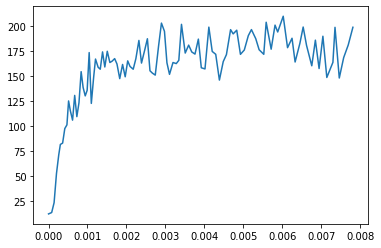

In [85]:
plt.plot(freqs**(-1), np.exp(lsq))

In [87]:
os.listdir()

['.config', 'adc.json', 'text8.zip', 'sample_data']

In [0]:
  embedding = tf.Variable(tf.random.normal([vocabulary_size, embedding_size]))
  # Construct the variables for the NCE loss.
  nce_weights = tf.Variable(tf.random.normal([vocabulary_size, embedding_size]))
  nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [0]:
np.save('embedding.npy',embedding.numpy())
np.save('nce_weights.npy',nce_weights.numpy())
np.save('nce_biases.npy',nce_biases.numpy())

In [0]:
# this would upload files to the Google Drive
for file_name in ['embedding.npy', 'nce_weights.npy', 'nce_biases.npy']:
  file = drive.CreateFile()
  file.SetContentFile(file_name)
  file.Upload()